# Goal

* tSNE plot of incorporator niche for each OTU
  * plotting each OTU based on which substrates/days each isotope was incorporated
* looking into ways of defining functional guilds by binning the OTUs based on their incorporator status

# Setting variables

In [1]:
import os
%load_ext rpy2.ipython
#%load_ext pushnote

In [2]:
%%R
workDir = '/home/chantal/Chazy/Bulk/515_806/data/'
figDir = '/home/chantal/Chazy/Bulk/515_806/data/figs/'

# physeq
physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqSIP = 'bulkSIP-core'

# log2 fold change
l2fcResDir = '/home/chantal/Chazy/Bulk/515_806/data/'
l2fcResFileTill = file.path(l2fcResDir, 'l2fc_Till.txt')
l2fcResFileOM = file.path(l2fcResDir, 'l2fc_sparse-maxRejH_bulk_OM.txt')
l2fcResFileTime = file.path(l2fcResDir, 'l2fc_sparse_Time.txt')



# tree files
treeFile = '/home/chantal/Chazy/data/otusn_515.tree'

# params
padj.cutoff = 0.10   # adjusted p-value cutoff for selecting incorporators
nprocs = 24

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


# Init

In [3]:
%Rpull workDir
workDir = workDir[0]
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
%cd $workDir    

/home/chantal/Chazy/Bulk/515_806/data


In [4]:
%%R
library(phyloseq)
library(tidyr)
library(ggplot2)
library(tsne)
library(kohonen)
library(dplyr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: class

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: MASS

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:MASS’:

    select


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaco

# Loading files

In [5]:
%%R 
# log2 fold change analysis results file
df.l2fc.Till = read.delim(l2fcResFileTill, sep='\t') %>%
    mutate(Rank2 = gsub('^__', '', Rank2),
           Rank3 = gsub('^__', '', Rank3),
           Rank4 = gsub('^__', '', Rank4),
           Rank5 = gsub('^__', '', Rank5),
           Rank6 = gsub('^__', '', Rank6),
           Rank7 = gsub('^__', '', Rank7))

df.l2fc.Till$LFC_Till = df.l2fc.Till$log2FoldChange
df.l2fc.Till$padj_Till = df.l2fc.Till$padj2
df.l2fc.Till$log2FoldChange = NULL
df.l2fc.Till$padj2 = NULL

df.l2fc.Till = select(df.l2fc.Till, OTU, Rank1:Rank8, LFC_Till, padj_Till)

df.l2fc.Till %>% head(n=3)

       OTU    Rank1          Rank2        Rank3                Rank4 Rank5
1 OTU.1739 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
2 OTU.1813 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
3  OTU.778 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
  Rank6 Rank7 Rank8   LFC_Till   padj_Till
1  <NA>  <NA>  <NA>  0.7472744 0.232794299
2  <NA>  <NA>  <NA> -1.4776103 0.004930342
3  <NA>  <NA>  <NA> -0.5231083 0.001639325


In [6]:
%%R 
# log2 fold change analysis results file
df.l2fc.OM = read.delim(l2fcResFileOM, sep='\t') %>%
    mutate(Rank2 = gsub('^__', '', Rank2),
           Rank3 = gsub('^__', '', Rank3),
           Rank4 = gsub('^__', '', Rank4),
           Rank5 = gsub('^__', '', Rank5),
           Rank6 = gsub('^__', '', Rank6),
           Rank7 = gsub('^__', '', Rank7))

df.l2fc.OM$LFC_OM = df.l2fc.OM$log2FoldChange
df.l2fc.OM$padj_OM = df.l2fc.OM$padj2
df.l2fc.OM$log2FoldChange = NULL
df.l2fc.OM$padj2 = NULL

df.l2fc.OM = select(df.l2fc.OM, OTU, Rank1:Rank8, LFC_OM, padj_OM)


df.l2fc.OM %>% head(n=3)

       OTU    Rank1          Rank2        Rank3                Rank4 Rank5
1 OTU.1739 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
2 OTU.1813 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
3  OTU.778 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
  Rank6 Rank7 Rank8      LFC_OM   padj_OM
1  <NA>  <NA>  <NA> -0.71456262 0.6694360
2  <NA>  <NA>  <NA> -0.60046199 0.8474916
3  <NA>  <NA>  <NA>  0.05599948 0.9974832


%%R 
# log2 fold change analysis results file
df.l2fc.Time = read.delim(l2fcResFileTime, sep='\t') %>%
    mutate(Rank2 = gsub('^__', '', Rank2),
           Rank3 = gsub('^__', '', Rank3),
           Rank4 = gsub('^__', '', Rank4),
           Rank5 = gsub('^__', '', Rank5),
           Rank6 = gsub('^__', '', Rank6),
           Rank7 = gsub('^__', '', Rank7))

df.l2fc.Time$LFC_Time = df.l2fc.Time$log2FoldChange
df.l2fc.Time$padj_Time = df.l2fc.Time$padj2
df.l2fc.Time$log2FoldChange = NULL
df.l2fc.Time$padj2 = NULL

df.l2fc.Time = select(df.l2fc.Time, OTU, Rank1:Rank8, LFC_Time, padj_Time)


df.l2fc.Time %>% head(n=3)


In [7]:
%%R
print(length(df.l2fc.Till$OTU))
print(length(df.l2fc.OM$OTU))
#print(length(df.l2fc.Time$OTU))

[1] 3963
[1] 3963


In [8]:
%%R
full_l2fc = full_join(df.l2fc.Till, df.l2fc.OM)
#full_l2fc = full_join(full_l2fc, df.l2fc.OM)
head(full_l2fc)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: c("OTU", "Rank1", "Rank2", "Rank3", "Rank4", "Rank5", "Rank6", "Rank7", "Rank8")

  res = super(Function, self).__call__(*new_args, **new_kwargs)


        OTU    Rank1          Rank2        Rank3                Rank4 Rank5
1  OTU.1739 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
2  OTU.1813 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
3   OTU.778 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
4  OTU.2180 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
5 OTU.12365 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
6  OTU.2343 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
  Rank6 Rank7 Rank8   LFC_Till    padj_Till      LFC_OM   padj_OM
1  <NA>  <NA>  <NA>  0.7472744 2.327943e-01 -0.71456262 0.6694360
2  <NA>  <NA>  <NA> -1.4776103 4.930342e-03 -0.60046199 0.8474916
3  <NA>  <NA>  <NA> -0.5231083 1.639325e-03  0.05599948 0.9974832
4  <NA>  <NA>  <NA> -0.2596505 6.014102e-01 -0.14337012 0.9974832
5  <NA>  <NA>  <NA> -0.1659235 7.433654e-01 -0.46298096 0.8044638
6  <NA>  <NA>  <NA>  1.6390159 9.209066e-06 -0.54901766 0.7793516


In [9]:
%%R
length(full_l2fc$OTU)

[1] 3963


# Selecting incorporators

In [10]:
%%R

df.inc = full_l2fc %>%
    filter(padj_Till <= padj.cutoff | padj_OM <= padj.cutoff)

cat('Total number of incorporator OTUs:', df.inc$OTU %>% unique %>% length, '\n')

Total number of incorporator OTUs: 2125 


In [11]:
%%R
head(df.inc)

       OTU    Rank1          Rank2        Rank3                Rank4 Rank5
1 OTU.1813 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
2  OTU.778 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
3 OTU.2343 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
4 OTU.1158 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
5 OTU.2014 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
6  OTU.598 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
  Rank6 Rank7 Rank8   LFC_Till    padj_Till      LFC_OM   padj_OM
1  <NA>  <NA>  <NA> -1.4776103 4.930342e-03 -0.60046199 0.8474916
2  <NA>  <NA>  <NA> -0.5231083 1.639325e-03  0.05599948 0.9974832
3  <NA>  <NA>  <NA>  1.6390159 9.209066e-06 -0.54901766 0.7793516
4  <NA>  <NA>  <NA>  0.5978779 3.807084e-02 -0.30203488 0.9974832
5  <NA>  <NA>  <NA>  1.2614712 9.065805e-03 -0.09105635 0.9974832
6  <NA>  <NA>  <NA>  1.3462593 3.164272e-08  0.24079797 0.9974832


In [13]:
%%R
df.Till = filter(df.inc, padj_Till <= 0.10, padj_OM >0.10)
#df.Time = filter(df.inc, padj_Till > 0.10, padj_Time <= 0.10, padj_OM >0.10)
df.OM = filter(df.inc, padj_Till > 0.10, padj_OM <= 0.10)

#df.Till_Time = filter(df.inc, padj_Till <= 0.10, padj_Time <=0.10, padj_OM > 0.10)
#df.Time_OM = filter(df.inc, padj_Till > 0.10, padj_Time <=0.10, padj_OM <= 0.10)
df.Till_OM = filter(df.inc, padj_Till <= 0.10, padj_OM <= 0.10)

#df.Till_Time_OM = filter(df.inc, padj_Till <= 0.10, padj_Time <= 0.10, padj_OM <= 0.10)

print(paste('Till only:', length(df.Till$OTU)))
#print(paste('Time only:',length(df.Time$OTU)))
print(paste('OM only:',length(df.OM$OTU)))

#print(paste('Till and Time:',length(df.Till_Time$OTU)))
#print(paste('OM and Time:',length(df.Time_OM$OTU)))
print(paste('Till and OM:',length(df.Till_OM$OTU)))

#print(paste('Till, OM, and Time:',length(df.Till_Time_OM$OTU)))

[1] "Till only: 1880"
[1] "OM only: 87"
[1] "Till and OM: 158"


## Using l2fc matrix for tSNE

In [14]:
%%R
head(full_l2fc)

        OTU    Rank1          Rank2        Rank3                Rank4 Rank5
1  OTU.1739 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
2  OTU.1813 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
3   OTU.778 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
4  OTU.2180 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
5 OTU.12365 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
6  OTU.2343 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
  Rank6 Rank7 Rank8   LFC_Till    padj_Till      LFC_OM   padj_OM
1  <NA>  <NA>  <NA>  0.7472744 2.327943e-01 -0.71456262 0.6694360
2  <NA>  <NA>  <NA> -1.4776103 4.930342e-03 -0.60046199 0.8474916
3  <NA>  <NA>  <NA> -0.5231083 1.639325e-03  0.05599948 0.9974832
4  <NA>  <NA>  <NA> -0.2596505 6.014102e-01 -0.14337012 0.9974832
5  <NA>  <NA>  <NA> -0.1659235 7.433654e-01 -0.46298096 0.8044638
6  <NA>  <NA>  <NA>  1.6390159 9.209066e-06 -0.54901766 0.7793516


In [15]:
%%R
full_l2fc$Till[full_l2fc$LFC_Till > 0 & full_l2fc$padj_Till <= 0.10] = "PT"
full_l2fc$Till[full_l2fc$LFC_Till <0 & full_l2fc$padj_Till <= 0.10] = "NT"
full_l2fc$OM[full_l2fc$LFC_OM > 0 & full_l2fc$padj_OM <= 0.10] = "Returned"
full_l2fc$OM[full_l2fc$LFC_OM <0 & full_l2fc$padj_OM <= 0.10] = "Harvested"
#full_l2fc$Time[full_l2fc$LFC_Time > 0 & full_l2fc$padj_Time <= 0.10] = "Increasing"
#full_l2fc$Time[full_l2fc$LFC_Time <0 & full_l2fc$padj_Time <= 0.10] = "Decreasing"

In [18]:
%%R 
# selecting all incorporator OTUs, keeping l2fc values for all substrates/days

cat('Total number of incorporator OTUs:', df.inc$OTU %>% unique %>% length, '\n')

df.l2fc.w = full_l2fc  %>%
    filter(OTU %in% df.inc$OTU)%>%
    unite(TO, Till, OM, sep='_') %>%
    dplyr::select(OTU, LFC_Till, LFC_OM) 
    #spread(TOT, LFC_Till) 
rownames(df.l2fc.w) = df.l2fc.w$OTU
df.l2fc.w$OTU = NULL

df.l2fc.w$LFC_Till[is.na(df.l2fc.w$LFC_Till)] = 0
df.l2fc.w$LFC_OM[is.na(df.l2fc.w$LFC_OM)] = 0
#df.l2fc.w$LFC_Time[is.na(df.l2fc.w$LFC_Time)] = 0
#df.l2fc.w %>% nrow %>% print
df.l2fc.w %>% head(n=3)


#NEGATIVE NUMBERS...

Total number of incorporator OTUs: 2125 
           LFC_Till      LFC_OM
OTU.1813 -1.4776103 -0.60046199
OTU.778  -0.5231083  0.05599948
OTU.2343  1.6390159 -0.54901766


In [19]:
%%R
tsne.res = tsne(df.l2fc.w)
saveRDS(tsne.res, 'tsne_l2fc')

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: sigma summary: Min. : 0.1652 |1st Qu. : 0.2021 |Median : 0.2312 |Mean : 0.2562 |3rd Qu. : 0.2873 |Max. : 0.6882 |

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #100 error is: 13.489170213851

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #200 error is: 0.879566570776766

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #300 error is: 0.677105296029154

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Epoch: Iteration #400 error is: 0.595357815

In [20]:
%%R
# formatting tSNE output
df.tsne.res = readRDS('tsne_l2fc') %>% as.data.frame
colnames(df.tsne.res) = c('tsne_axis1', 'tsne_axis2')
#df.tsne.res = as.data.frame(tsne.res)
df.tsne.res$OTU = rownames(df.l2fc.w)
df.tsne.res %>% head

  tsne_axis1 tsne_axis2      OTU
1 -39.625933 -15.534223 OTU.1813
2   3.117823  47.762822  OTU.778
3  29.965277  48.030917 OTU.2343
4 -51.573916  27.061935 OTU.1158
5 -19.099700  28.488898 OTU.2014
6  26.743018   1.870923  OTU.598


### Adding clusters based on t-SNE distribution

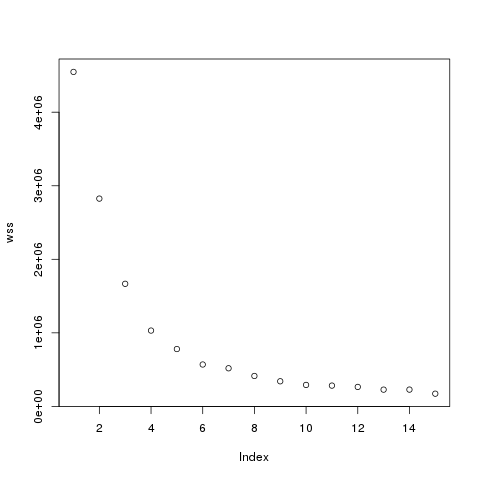

In [21]:
%%R
# kmeans
mydata = tsne.res 
wss = (nrow(mydata)-1)*sum(apply(mydata,2,var)) 
for (i in 2:15) {
  wss[i] = sum(kmeans(mydata, centers=i)$withinss)
}
plot(wss)

In [22]:
%%R
## use hierarchical clustering to cluster the codebook vectors
n.clusts = 4
df.tsne.res$tsne_cluster = cutree(hclust(dist(tsne.res)), n.clusts) %>% as.vector 
df.tsne.res = df.tsne.res %>%
    mutate(tsne_cluster = tsne_cluster %>% as.character)
df.tsne.res %>% head

  tsne_axis1 tsne_axis2      OTU tsne_cluster
1 -39.625933 -15.534223 OTU.1813            1
2   3.117823  47.762822  OTU.778            2
3  29.965277  48.030917 OTU.2343            2
4 -51.573916  27.061935 OTU.1158            1
5 -19.099700  28.488898 OTU.2014            1
6  26.743018   1.870923  OTU.598            3


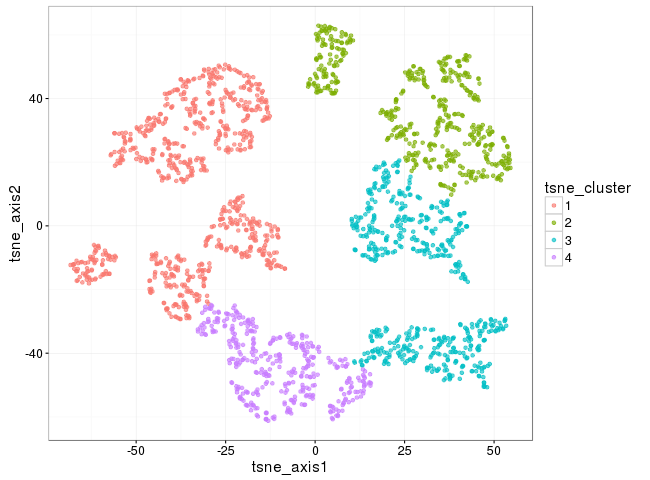

In [23]:
%%R -w 650

ggplot(df.tsne.res, aes(tsne_axis1, tsne_axis2, color=tsne_cluster)) +
    geom_point(alpha=0.65) +
    scale_size(range=c(1, 10), trans='exp') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [23]:
%%R
pvc.res = pvclust::pvclust(df.l2fc.w %>% t, 
                           method.hclust='average', 
                           method.dist='correlation',
                           nboot=10000, 
                           parallel=TRUE)
plot(pvc.res, labels=FALSE)
pvclust::pvrect(pvc.res)

Creating a temporary cluster...done:
socket cluster with 39 nodes on host ‘localhost’
Multiscale bootstrap...
Error in checkForRemoteErrors(val) : 
  39 nodes produced errors; first error: supply both 'x' and 'y' or a matrix-like 'x'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in checkForRemoteErrors(val) : 
  39 nodes produced errors; first error: supply both 'x' and 'y' or a matrix-like 'x'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 

 

In [24]:
%%R
pvclust::msplot(pvc.res, edges=c(1,2,3,4))


Error in plot(x$msfit[[i]], main = main, ...) : 
  object 'pvc.res' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in plot(x$msfit[[i]], main = main, ...) : 
  object 'pvc.res' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [25]:
%%R
# number of significant clusters
pvc.clusts = pvclust::pvpick(pvc.res)
pvc.clusts$clusters %>% length


Error in nrow(x$edges) : object 'pvc.res' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in nrow(x$edges) : object 'pvc.res' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [26]:
%%R -w 600 -h 350
# size of each cluster
do.call(rbind, lapply(pvc.clusts$clusters, length)) %>% 
    as.vector %>% 
    hist(binwidth=1, main='Cluster size')


Error in lapply(pvc.clusts$clusters, length) : 
  object 'pvc.clusts' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in lapply(pvc.clusts$clusters, length) : 
  object 'pvc.clusts' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


### Appending tsne values to metadata

In [24]:
%%R
head(full_l2fc)

        OTU    Rank1          Rank2        Rank3                Rank4 Rank5
1  OTU.1739 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
2  OTU.1813 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
3   OTU.778 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
4  OTU.2180 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
5 OTU.12365 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
6  OTU.2343 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
  Rank6 Rank7 Rank8   LFC_Till    padj_Till      LFC_OM   padj_OM Till   OM
1  <NA>  <NA>  <NA>  0.7472744 2.327943e-01 -0.71456262 0.6694360 <NA> <NA>
2  <NA>  <NA>  <NA> -1.4776103 4.930342e-03 -0.60046199 0.8474916   NT <NA>
3  <NA>  <NA>  <NA> -0.5231083 1.639325e-03  0.05599948 0.9974832   NT <NA>
4  <NA>  <NA>  <NA> -0.2596505 6.014102e-01 -0.14337012 0.9974832 <NA> <NA>
5  <NA>  <NA>  <NA> -0.1659235 7.433654e-01 -0.46298096 0.8044638 <NA> <NA>
6  <NA>  <NA

In [27]:
%%R
df.l2fc.nSub = inner_join(full_l2fc, df.tsne.res, c('OTU' = 'OTU'))

df.l2fc.nSub$Status = paste(df.l2fc.nSub$Till, df.l2fc.nSub$OM, sep = '_')

df.l2fc.nSub %>% nrow %>% print
df.l2fc.nSub %>% head(n=10) %>% as.data.frame

[1] 2125
        OTU    Rank1          Rank2        Rank3                Rank4 Rank5
1  OTU.1813 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
2   OTU.778 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
3  OTU.2343 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
4  OTU.1158 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
5  OTU.2014 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
6   OTU.598 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
7   OTU.940 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
8  OTU.1547 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
9  OTU.1704 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
10 OTU.1844 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
   Rank6 Rank7 Rank8   LFC_Till    padj_Till      LFC_OM     padj_OM Till
1   <NA>  <NA>  <NA> -1.4776103 4.930342e-03 -0.60046199 0.847491612   NT
2   <NA

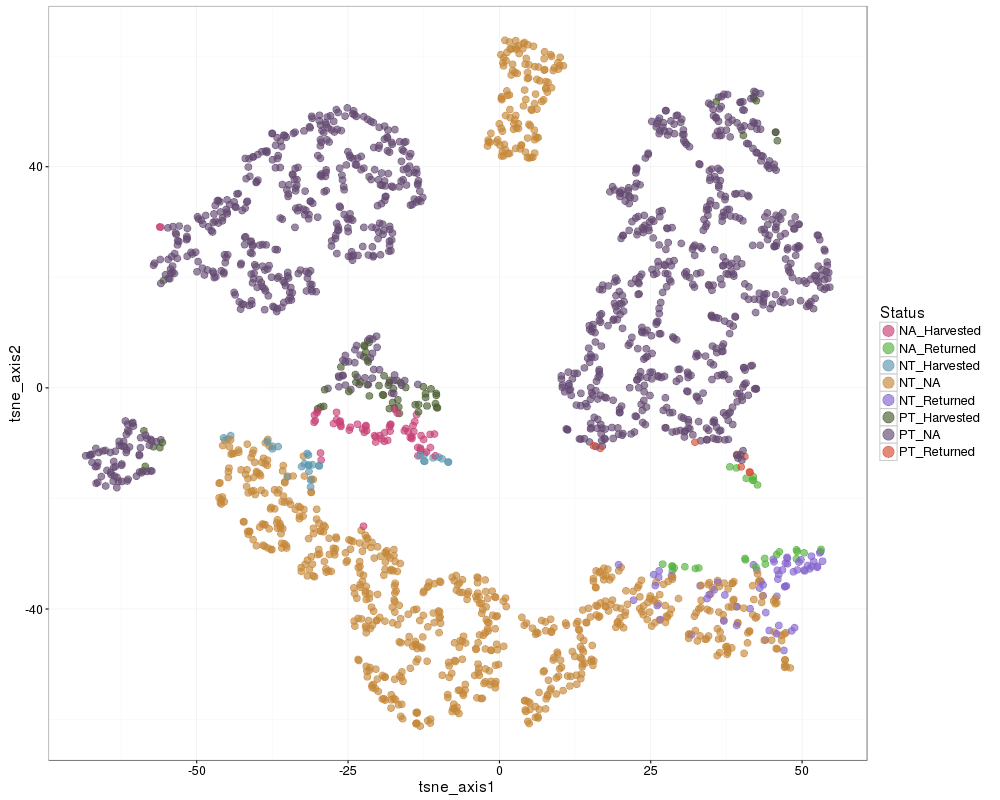

In [28]:
%%R -w 1000 -h 800

colors = c("#C83F76",
"#55B23D",
"#5C97AD",
"#C58839",
"#8364CC",
"#485D2E",
"#624871",
"#D64C32",
"#55A87B",
"#954A3D",
"#CB83AD",
"#94A13C",
"#CC4FC8",
"#778AD2")

ggplot(df.l2fc.nSub, aes(tsne_axis1, tsne_axis2, color=Status)) +
    geom_point(alpha=0.65, size = 3) +
    scale_size(range=c(1, 10), trans='exp') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    ) + scale_color_manual(values = colors) + guides(colour = guide_legend(override.aes = list(size=5))) 

In [29]:
%%R
df.l2fc.nSub$sigstatT[df.l2fc.nSub$LFC_Till > 0 & df.l2fc.nSub$padj_Till <= 0.10] = "PT"
df.l2fc.nSub$sigstatT[df.l2fc.nSub$LFC_Till <0 & df.l2fc.nSub$padj_Till <= 0.10] = "NT"
df.l2fc.nSub$sigstatO[df.l2fc.nSub$LFC_OM > 0 & df.l2fc.nSub$padj_OM <= 0.10] = "Returned"
df.l2fc.nSub$sigstatO[df.l2fc.nSub$LFC_OM <0 & df.l2fc.nSub$padj_OM <= 0.10] = "Harvested"

df.l2fc.nSub$sigstatT[df.l2fc.nSub$LFC_Till > 0 & df.l2fc.nSub$padj_Till > 0.10] = "NS.Till"
df.l2fc.nSub$sigstatT[df.l2fc.nSub$LFC_Till <0 & df.l2fc.nSub$padj_Till > 0.10] = "NS.Till"
df.l2fc.nSub$sigstatO[df.l2fc.nSub$LFC_OM > 0 & df.l2fc.nSub$padj_OM > 0.10] = "NS.OM"
df.l2fc.nSub$sigstatO[df.l2fc.nSub$LFC_OM <0 & df.l2fc.nSub$padj_OM > 0.10] = "NS.OM"

df.l2fc.nSub$sigstatT[is.na(df.l2fc.nSub$LFC_Till)] = "NA.Till"
df.l2fc.nSub$sigstatO[is.na(df.l2fc.nSub$LFC_OM)] = "NA.OM"


In [30]:
%%R
df.l2fc.nSub$sigstat = paste(df.l2fc.nSub$sigstatT, df.l2fc.nSub$sigstatO, sep = '_')
head(df.l2fc.nSub)

       OTU    Rank1          Rank2        Rank3                Rank4 Rank5
1 OTU.1813 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
2  OTU.778 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
3 OTU.2343 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
4 OTU.1158 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>
5 OTU.2014 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
6  OTU.598 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>
  Rank6 Rank7 Rank8   LFC_Till    padj_Till      LFC_OM   padj_OM Till   OM
1  <NA>  <NA>  <NA> -1.4776103 4.930342e-03 -0.60046199 0.8474916   NT <NA>
2  <NA>  <NA>  <NA> -0.5231083 1.639325e-03  0.05599948 0.9974832   NT <NA>
3  <NA>  <NA>  <NA>  1.6390159 9.209066e-06 -0.54901766 0.7793516   PT <NA>
4  <NA>  <NA>  <NA>  0.5978779 3.807084e-02 -0.30203488 0.9974832   PT <NA>
5  <NA>  <NA>  <NA>  1.2614712 9.065805e-03 -0.09105635 0.9974832   PT <NA>
6  <NA>  <NA>  <NA>

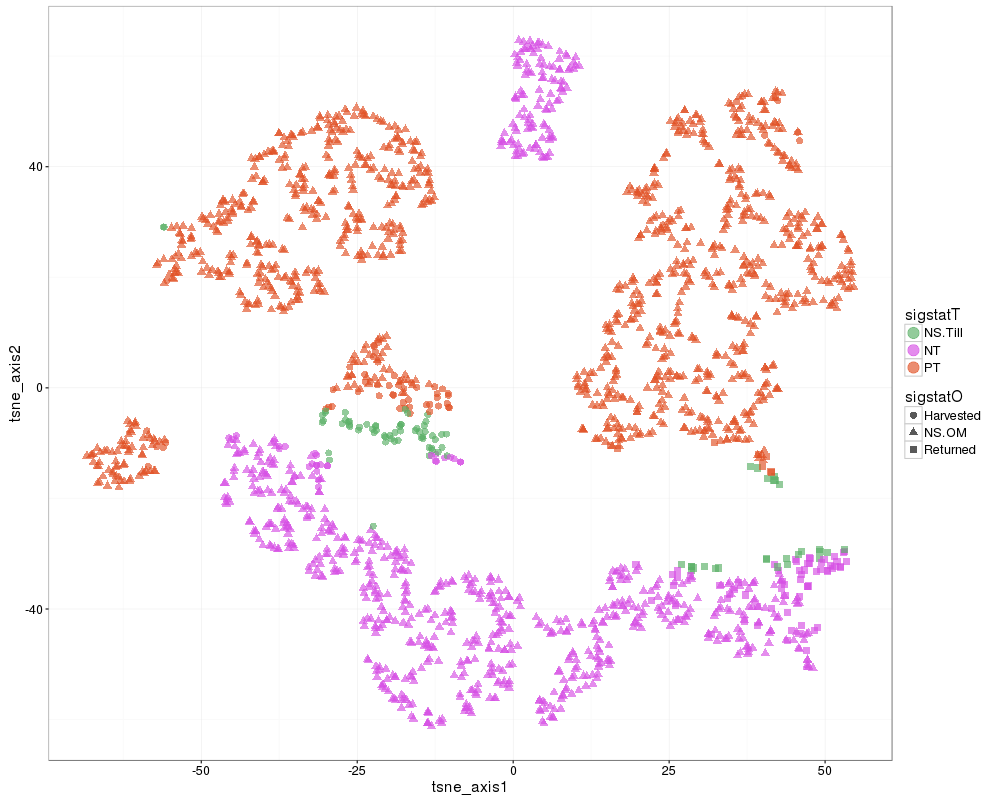

In [32]:
%%R -w 1000 -h 800

colors = c("#59AF65",
"#D54FE3",
"#E05024",
"#559ADA",
"#CF7787",
"#BEA435",
"#485267",
"#5A4A9F",
"#795323",
"#AE2D79",
"#43612A",
"#C885DB",
"#5DB52F",
"#61B5C9",
"#973620",
"#50B196",
"#316B60",
"#8B6AE5",
"#833A46",
"#DA444F",
"#6D4270",
"#D28939",
"#DF46B8",
"#D57A62",
"#5F7EDE",
"#889B41",
"#33548B",
"#BD8CAF",
"#E073AE",
"#9E48AA",
"#DA3F77",
"#A6A3E0",
"#8170A6",
"#648CA8",
"#812D6E")

ggplot(df.l2fc.nSub, aes(tsne_axis1, tsne_axis2, color=sigstatT, shape = sigstatO)) +
    geom_point(alpha=0.65, size = 3) +
    scale_size(range=c(1, 10), trans='exp') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    ) + scale_color_manual(values = colors) + guides(colour = guide_legend(override.aes = list(size=5))) 

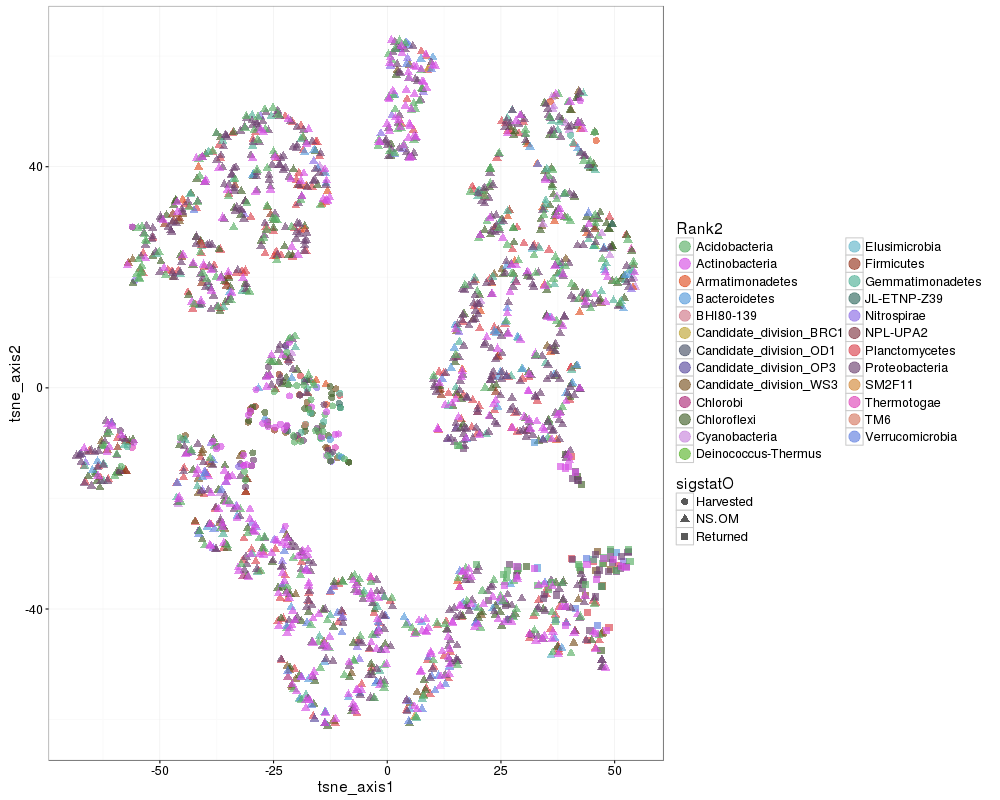

In [35]:
%%R -w 1000 -h 800

colors = c("#59AF65",
"#D54FE3",
"#E05024",
"#559ADA",
"#CF7787",
"#BEA435",
"#485267",
"#5A4A9F",
"#795323",
"#AE2D79",
"#43612A",
"#C885DB",
"#5DB52F",
"#61B5C9",
"#973620",
"#50B196",
"#316B60",
"#8B6AE5",
"#833A46",
"#DA444F",
"#6D4270",
"#D28939",
"#DF46B8",
"#D57A62",
"#5F7EDE",
"#889B41",
"#33548B",
"#BD8CAF",
"#E073AE",
"#9E48AA",
"#DA3F77",
"#A6A3E0",
"#8170A6",
"#648CA8",
"#812D6E")

ggplot(df.l2fc.nSub, aes(tsne_axis1, tsne_axis2, color= Rank2, shape = sigstatO)) +
    geom_point(alpha=0.65, size = 3) +
    scale_size(range=c(1, 10), trans='exp') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    ) + scale_color_manual(values = colors) + guides(colour = guide_legend(override.aes = list(size=5))) 

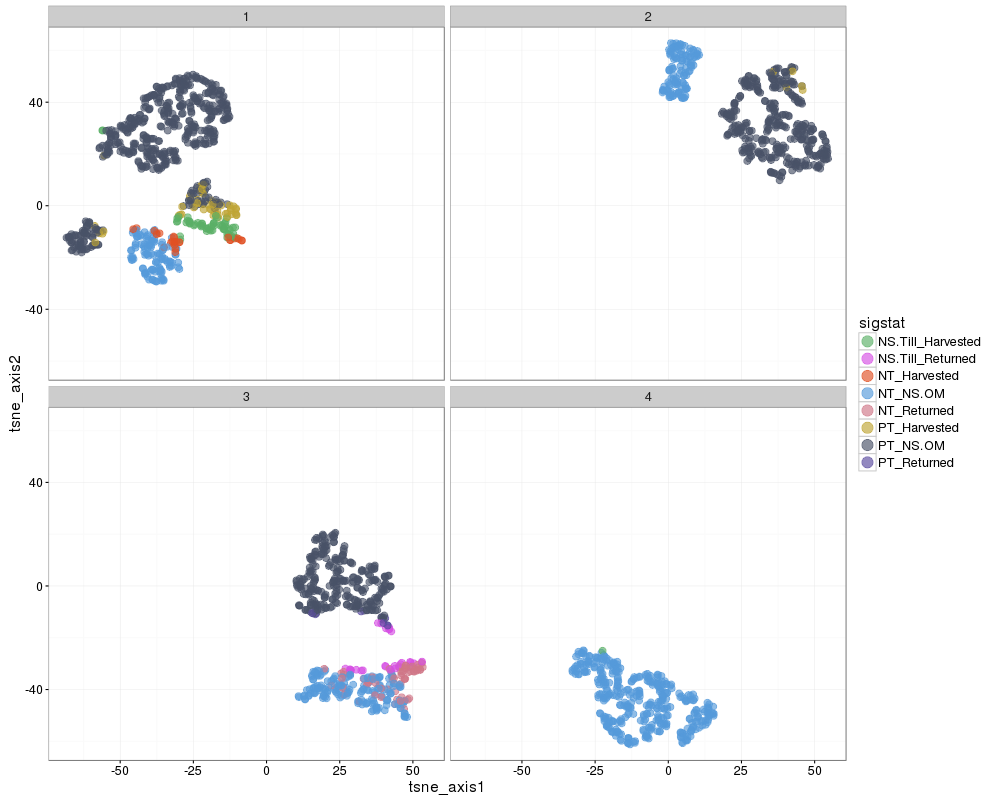

In [36]:
%%R -w 1000 -h 800

colors = c("#59AF65",
"#D54FE3",
"#E05024",
"#559ADA",
"#CF7787",
"#BEA435",
"#485267",
"#5A4A9F",
"#795323",
"#AE2D79",
"#43612A",
"#C885DB",
"#5DB52F",
"#61B5C9",
"#973620",
"#50B196",
"#316B60",
"#8B6AE5",
"#833A46",
"#DA444F",
"#6D4270",
"#D28939",
"#DF46B8",
"#D57A62",
"#5F7EDE",
"#889B41",
"#33548B",
"#BD8CAF",
"#E073AE",
"#9E48AA",
"#DA3F77",
"#A6A3E0",
"#8170A6",
"#648CA8",
"#812D6E")

ggplot(df.l2fc.nSub, aes(tsne_axis1, tsne_axis2, color=sigstat)) +
    geom_point(alpha=0.65, size = 3) +
    scale_size(range=c(1, 10), trans='exp') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    ) + scale_color_manual(values = colors) + guides(colour = guide_legend(override.aes = list(size=5))) + 
    facet_wrap(~tsne_cluster)

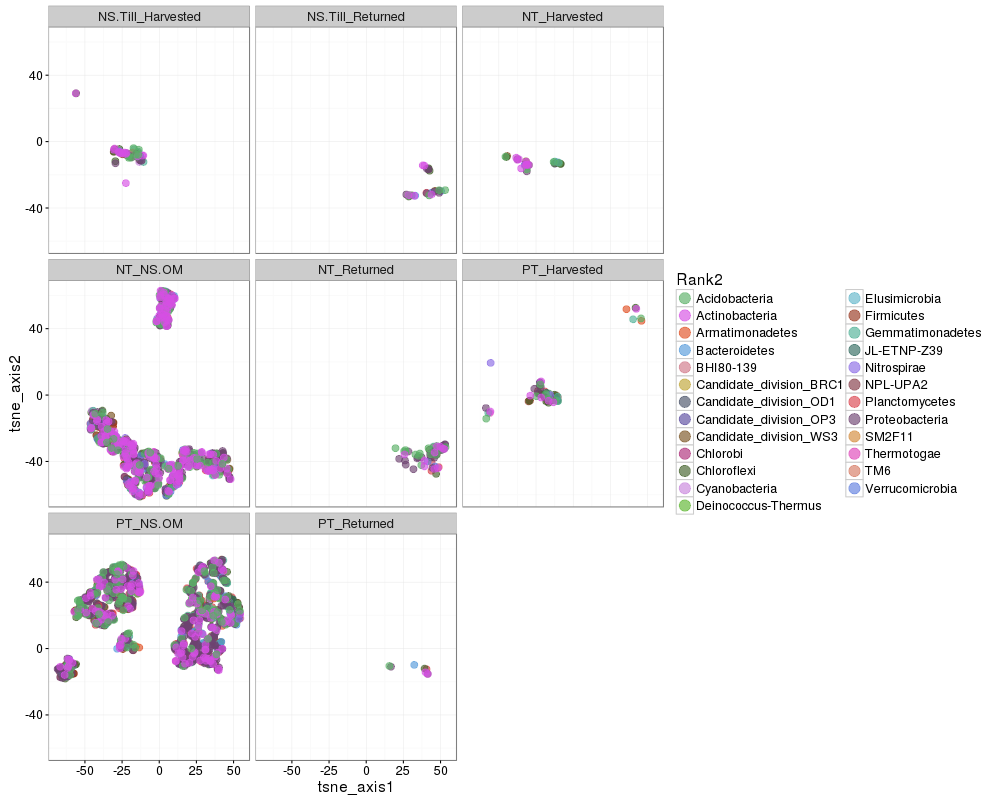

In [39]:
%%R -w 1000 -h 800

colors = c("#59AF65",
"#D54FE3",
"#E05024",
"#559ADA",
"#CF7787",
"#BEA435",
"#485267",
"#5A4A9F",
"#795323",
"#AE2D79",
"#43612A",
"#C885DB",
"#5DB52F",
"#61B5C9",
"#973620",
"#50B196",
"#316B60",
"#8B6AE5",
"#833A46",
"#DA444F",
"#6D4270",
"#D28939",
"#DF46B8",
"#D57A62",
"#5F7EDE",
"#889B41",
"#33548B",
"#BD8CAF",
"#E073AE",
"#9E48AA",
"#DA3F77",
"#A6A3E0",
"#8170A6",
"#648CA8",
"#812D6E")

ggplot(df.l2fc.nSub, aes(tsne_axis1, tsne_axis2, color=Rank2)) +
    geom_point(alpha=0.65, size = 3) +
    scale_size(range=c(1, 10), trans='exp') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    ) + scale_color_manual(values = colors) + guides(colour = guide_legend(override.aes = list(size=5))) + 
    facet_wrap(~sigstat)

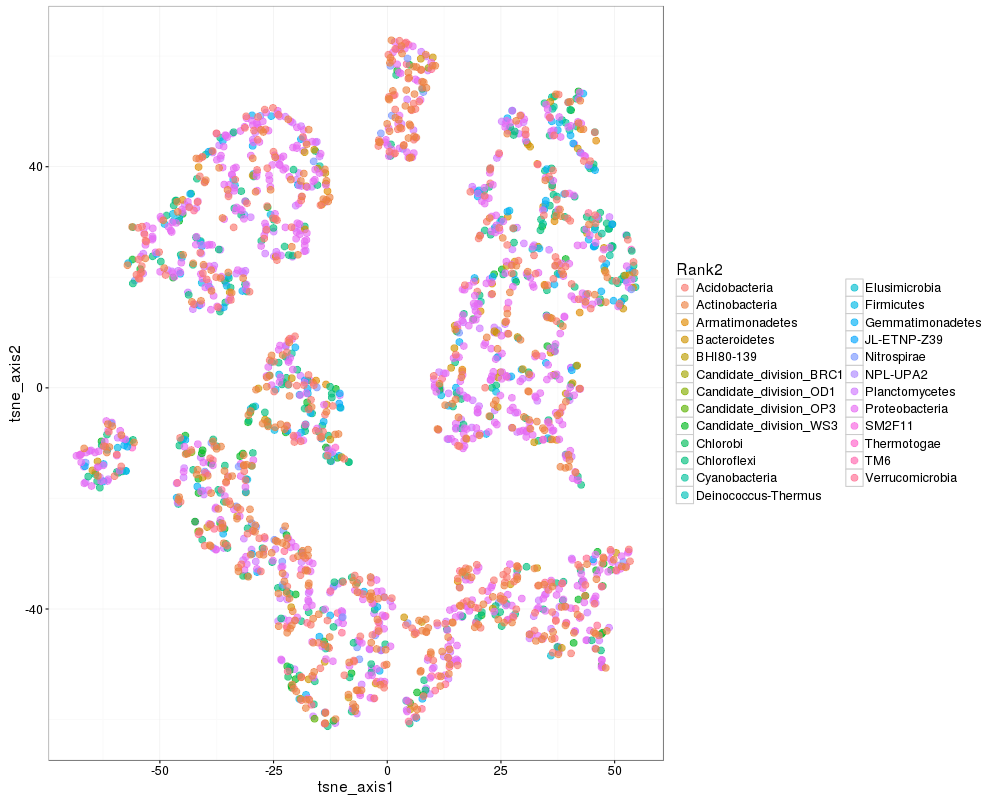

In [38]:
%%R -w 1000 -h 800

colors = c("#C83F76",
"#55B23D",
"#5C97AD",
"#C58839",
"#8364CC",
"#485D2E",
"#624871",
"#D64C32",
"#55A87B",
"#954A3D",
"#CB83AD",
"#94A13C",
"#CC4FC8",
"#778AD2")

ggplot(df.l2fc.nSub, aes(tsne_axis1, tsne_axis2, color=Rank2)) +
    geom_point(alpha=0.65, size = 3) +
    scale_size(range=c(1, 10), trans='exp') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    ) #+ scale_color_manual(values = colors) + guides(colour = guide_legend(override.aes = list(size=5))) 

In [36]:
%%R
test = filter(df.l2fc.nSub, Status == 'PT_Harvested_Decreasing') 
head(test)

 [1] OTU          Rank1        Rank2        Rank3        Rank4       
 [6] Rank5        Rank6        Rank7        Rank8        LFC_Till    
[11] padj_Till    LFC_Time     padj_Time    LFC_OM       padj_OM     
[16] Till         OM           Time         tsne_axis1   tsne_axis2  
[21] tsne_cluster Status       sigstatT     sigstatO     sigstatTime 
[26] sigstat     
<0 rows> (or 0-length row.names)


### Plotting by t-SNE cluster

### Plotting by phylum

In [37]:
%%R -w 700

ggplot(df.l2fc.nSub, aes(tsne_axis1, tsne_axis2, color=Rank2, size=Incorp_nSubs)) +
    geom_point(alpha=0.65) +
    scale_size(range=c(1, 10), trans='exp') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'Incorp_nSubs' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


RRuntimeError: Error in eval(expr, envir, enclos) : object 'Incorp_nSubs' not found


In [ ]:
%%R -w 700

ggplot(df.l2fc.nSub, aes(tsne_axis1, tsne_axis2, color=Month, size=Incorp_nSubs)) +
    geom_point(alpha=0.65) +
    scale_size(range=c(1, 10), trans='exp') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Just plotting proteos

In [ ]:
%%R -w 700

df.l2fc.nSub.proteo = df.l2fc.nSub %>%
    filter(Rank2 == 'Proteobacteria')

ggplot(df.l2fc.nSub.proteo, aes(tsne_axis1, tsne_axis2, color=Rank3, size=Incorp_nSubs)) +
    geom_point(alpha=0.65) +
    scale_size(range=c(1, 10), trans='exp') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Plotting which substrates incorporated

In [ ]:
%%R
# incorporator of a particular substrate
df.l2fc.aSub = df.l2fc %>% 
    filter(OTU %in% df.inc$OTU) %>%
    group_by(OTU, Till) %>%
    mutate(Incorp_for_sub = any(Incorporator) %>% as.numeric) %>%
    distinct(OTU, Till) %>%
    dplyr::select(-log2FoldChange, -padj, -padj2, -Incorporator) 

df.l2fc.aSub = inner_join(df.l2fc.aSub %>% filter(Incorp_for_sub == 1), 
                          df.tsne.res, c('OTU' = 'OTU'))

df.l2fc.aSub %>% nrow %>% print
df.l2fc.aSub %>% head(n=3) %>% as.data.frame

In [ ]:
%%R -w 900 -h 650

ggplot(df.l2fc.aSub, aes(tsne_axis1, tsne_axis2, color=Rank2)) +
    geom_point(alpha=0.5) +
    facet_wrap(~ Till) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [ ]:
%%R -w 900 -h 650

ggplot(df.l2fc.aSub, aes(tsne_axis1, tsne_axis2, color=Rank2)) +
    geom_point(alpha=0.5) +
    facet_wrap(~Till) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [ ]:
%%R
filter(df.l2fc.aSub, Month == 'April', Till == 'NT')

In [ ]:
%%R
filter(df.l2fc, Month == 'April', Till == "NT", padj2 <= 0.05)

### Plotting with t-sne clusters

In [ ]:
%%R -w 900 -h 650

ggplot(df.l2fc.aSub, aes(tsne_axis1, tsne_axis2, color=tsne_cluster)) +
    geom_point(alpha=0.5) +
    facet_wrap(~ Till) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## Plotting by day

In [ ]:
%%R
# incorporator of a particular substrate
df.l2fc.aDay = df.l2fc %>% 
    filter(OTU %in% df.inc$OTU) %>%
    group_by(OTU, Day) %>%
    mutate(Incorp_for_sub = any(Incorporator) %>% as.numeric) %>%
    distinct(OTU, Day) %>%
    dplyr::select(-Substrate, -Microcosm_replicate, -log2FoldChange, -p, -padj, -Incorporator) 

df.l2fc.aDay = inner_join(df.l2fc.aDay %>% filter(Incorp_for_sub == 1), 
                          df.tsne.res, c('OTU' = 'OTU'))

df.l2fc.aDay %>% nrow %>% print
df.l2fc.aDay %>% head(n=3) %>% as.data.frame

In [ ]:
%%R -w 800
# just by day
ggplot(df.l2fc.aDay, aes(tsne_axis1, tsne_axis2, color=tsne_cluster)) +
    geom_point(alpha=0.5) +
    facet_wrap( ~ Day) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## Plotting by substrate &  time

* late vs early incoporators


In [ ]:
%%R

# just incorporators
df.l2fc.inc = df.l2fc %>% 
    filter(Incorporator == 1) 
df.l2fc.inc = inner_join(df.l2fc.inc, 
                         df.tsne.res, c('OTU' = 'OTU'))

df.l2fc.inc %>% nrow %>% print
df.l2fc.inc %>% arrange(OTU) %>% head(n=3) %>% as.data.frame

In [ ]:
%%R -w 950 -h 950

# coloring by phylum
ggplot(df.l2fc.inc, aes(tsne_axis1, tsne_axis2, color=Rank2)) +
    geom_point(alpha=0.5) +
    facet_grid(Substrate ~ Day) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [ ]:
%%R -w 950 -h 950

# color by tsne cluster
ggplot(df.l2fc.inc, aes(tsne_axis1, tsne_axis2, color=tsne_cluster)) +
    geom_point(alpha=0.5) +
    facet_grid(Substrate ~ Day) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Suming number of incorporators in each t-SNE cluster for each treatment/day

In [ ]:
%%R -w 800

df.l2fc.inc.sum = df.l2fc.inc %>%
    group_by(Substrate, Day, tsne_cluster) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    complete(Substrate, Day, tsne_cluster) %>%
    mutate(n = ifelse(is.na(n), 0, n))

ggplot(df.l2fc.inc.sum, aes(Day, n, color=Substrate)) +
    geom_point() +
    geom_line() +
    labs(title='Number of incorporators for each t-SNE cluster') +
    facet_wrap(~ tsne_cluster) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Plotting l2fc by t-SNE cluster

In [ ]:
%%R
# incorporators of any substrate
df.l2fc.aInc = df.l2fc %>% 
    group_by(OTU) %>%
    filter(any(Incorporator)) %>%
    ungroup()

df.l2fc.aInc = inner_join(df.l2fc.aInc, 
                          df.tsne.res, c('OTU' = 'OTU'))

df.l2fc.aInc %>% nrow %>% print
df.l2fc.aInc %>% head(n=3) %>% as.data.frame

In [ ]:
%%R -w 800
df.l2fc.aInc.sum = df.l2fc.aInc %>%
    group_by(Substrate, Day, tsne_cluster) %>%
    summarize(median_l2fc = median(log2FoldChange)) %>%
    ungroup() %>%
    complete(Substrate, Day, tsne_cluster) %>%
    mutate(median_l2fc = ifelse(is.na(median_l2fc), 0, median_l2fc))

ggplot(df.l2fc.aInc.sum, aes(Day, median_l2fc, color=Substrate)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept=0, alpha=0.25) +
    labs(y='Median log2 fold change') +
    facet_wrap(~ tsne_cluster) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Taxonomic composition of functional groups

In [ ]:
%%R -w 900
# taxonomy of the functional groups
df.l2fc.inc.sum = df.l2fc.inc %>%
    distinct(OTU, Day) %>%
    group_by(Day, tsne_cluster, Rank2) %>%
    summarize(n = n()) 

df.l2fc.inc.sum$Day = reorder(df.l2fc.inc.sum$Day %>% as.character, df.l2fc.inc.sum$Day)

ggplot(df.l2fc.inc.sum, aes(Day, n, fill=Rank2)) +
    geom_bar(stat='identity', position='fill') +
    labs(y='Fraction of incorporators') +
    facet_wrap(~ tsne_cluster) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

In [ ]:
%%R -w 900
# taxonomy of the functional groups
df.l2fc.inc.sum = df.l2fc.inc %>%
    distinct(OTU, Day) %>%
    filter(Rank2 == 'Proteobacteria') %>%
    group_by(Day, tsne_cluster, Rank3) %>%
    summarize(n = n()) 

df.l2fc.inc.sum$Day = reorder(df.l2fc.inc.sum$Day %>% as.character, df.l2fc.inc.sum$Day)

ggplot(df.l2fc.inc.sum, aes(Day, n, fill=Rank3)) +
    geom_bar(stat='identity', position='fill') +
    labs(y='Fraction of Proteobacteria incorporators') +
    facet_wrap(~ tsne_cluster) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# SOM

* using self organizing map + t-SNE to ID functional groups

In [ ]:
%%R
mtx.train = as.matrix(scale(df.l2fc.w))
mtx.train %>% head(n=3)

In [ ]:
%%R
# assuming ~X groupings
n.expect = 40
dim.size = floor(sqrt(n.expect * 10))
som_grid = somgrid(xdim=dim.size, ydim=dim.size, top='hexagonal')
som_model = som(mtx.train,
                grid = som_grid,
                n.hood='circular')


In [ ]:
%%R
plot(som_model, type="changes")

In [ ]:
%%R
plot(som_model, type="count")

In [ ]:
%%R
plot(som_model, type="dist.neighbours")

In [ ]:
%%R
plot(som_model, type="codes")

In [ ]:
%%R
mydata = som_model$codes 
wss = (nrow(mydata)-1)*sum(apply(mydata,2,var)) 
for (i in 2:15) {
  wss[i] = sum(kmeans(mydata, centers=i)$withinss)
}
plot(wss)

In [ ]:
%%R
## use hierarchical clustering to cluster the codebook vectors
n.clusts = 6
som_cluster <- cutree(hclust(dist(som_model$codes)), n.clusts)
som_cluster %>% head

In [ ]:
%%R
cols = rainbow(n.clusts)

# plot these results:
plot(som_model, type="mapping", bgcol = cols[som_cluster], main = "Clusters") 
add.cluster.boundaries(som_model, som_cluster)

In [ ]:
%%R
# mapping of data to grid nodes
df.l2fc.w.som = df.l2fc.w
df.l2fc.w.som$som_cluster = som_cluster[som_model$unit.classif]
df.l2fc.w.som$OTU = rownames(df.l2fc.w.som)
df.l2fc.w.som %>% head(n=3)

### Appending tsne values to metadata

In [ ]:
%%R
# incorporator of a particular substrate
df.l2fc.aSub = df.l2fc %>% 
    filter(OTU %in% df.inc$OTU) %>%
    group_by(OTU, Substrate) %>%
    mutate(Incorp_for_sub = any(Incorporator) %>% as.numeric) %>%
    distinct(OTU, Substrate) %>%
    dplyr::select(-Day, -Microcosm_replicate, -log2FoldChange, -p, -padj, -Incorporator) 

df.l2fc.aSub = inner_join(df.l2fc.aSub %>% filter(Incorp_for_sub == 1), 
                          df.tsne.res, c('OTU' = 'OTU'))

# joining with SOM clusters
df.l2fc.aSub = inner_join(df.l2fc.aSub, 
                          df.l2fc.w.som %>% 
                              dplyr::select(OTU, som_cluster) %>%
                              mutate(som_cluster = som_cluster %>% as.character), 
                          c('OTU' = 'OTU'))

# writing
df.l2fc.aSub %>% nrow %>% print
df.l2fc.aSub %>% head(n=3) %>% as.data.frame

### Plotting t-SNE with SOM cluster colors

In [ ]:
%%R -w 600 -h 450

ggplot(df.l2fc.aSub, aes(tsne_axis1, tsne_axis2, color=som_cluster)) +
    geom_point() +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### faceting by substrate(s) incorporated

In [ ]:
%%R -w 900 -h 650

ggplot(df.l2fc.aSub, aes(tsne_axis1, tsne_axis2, color=som_cluster)) +
    geom_point(alpha=0.5) +
    facet_wrap(~ Substrate) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

***
***

In [ ]:
%%R
# kmeans
mydata = tsne.res 
wss = (nrow(mydata)-1)*sum(apply(mydata,2,var)) 
for (i in 2:15) {
  wss[i] = sum(kmeans(mydata, centers=i)$withinss)
}
plot(wss)

In [ ]:
%%R
## use hierarchical clustering to cluster the codebook vectors
n.clusts = 5

df.tsne.res$cluster = cutree(hclust(dist(tsne.res)), n.clusts) %>% as.vector 
 
df.tsne.res %>% head

***
***

# SOM Sandbox

In [ ]:
%%R
library(kohonen)

In [ ]:
%%R
data_train = iris[,c(1,2,3,4)]
data_train_matrix = as.matrix(scale(data_train))
data_train_matrix %>% head

In [ ]:
%%R
# grid size?
floor(sqrt(iris %>% nrow))

In [ ]:
%%R -w 250 -h 250
som_grid = somgrid(xdim=12, ydim=12, topo='hexagonal')

ggplot(som_grid$pts %>% as.data.frame, aes(x, y)) +
    geom_point() +
    theme_bw()

In [ ]:
%%R
som_model = som(data_train_matrix,
               grid=som_grid,
               rlen=100,
               alpha=c(0.05,0.01),
               keep.data=TRUE,
               n.hood='circular')
som_model

In [ ]:
%%R
plot(som_model, type='changes')

In [ ]:
%%R
plot(som_model, type='count')

In [ ]:
%%R
plot(som_model, type="dist.neighbours")

In [ ]:
%%R
plot(som_model, type="codes")

In [ ]:
%%R
mydata <- som_model$codes 
wss <- (nrow(mydata)-1)*sum(apply(mydata,2,var)) 
for (i in 2:15) {
  wss[i] <- sum(kmeans(mydata, centers=i)$withinss)
}
plot(wss)

In [ ]:
%%R
## use hierarchical clustering to cluster the codebook vectors
n.clusts = 4
som_cluster <- cutree(hclust(dist(som_model$codes)), n.clusts)
som_cluster %>% head

In [ ]:
%%R
# mapping of data to grid nodes
som_model$unit.classif

In [ ]:
%%R
cols = rainbow(n.clusts)

# plot these results:
plot(som_model, type="mapping", bgcol = cols[som_cluster], main = "Clusters") 
add.cluster.boundaries(som_model, som_cluster)